In [93]:
import cv2
from pathlib import Path
from dateutil.rrule import rrule, DAILY, MONTHLY
from datetime import date
from calendar import monthrange
import numpy as np
import matplotlib.pyplot as plt
import requests
from owslib.wms import WebMapService

In [50]:
wms = WebMapService('https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi')

In [104]:
layer = 'MODIS_Terra_CorrectedReflectance_TrueColor'
layer = 'MODIS_Aqua_CorrectedReflectance_TrueColor'
wms[layer].timepositions

['2002-07-03/2019-11-08/P1D']

In [51]:
list(wms.contents)

['NASA_GIBS_EPSG4326_best',
 'Agricultural_Lands_Croplands_2000',
 'Agricultural_Lands_Pastures_2000',
 'AIRS_CO_Total_Column_Day',
 'AIRS_CO_Total_Column_Night',
 'AIRS_Dust_Score_Ocean_Day',
 'AIRS_Dust_Score_Ocean_Night',
 'AIRS_L2_Carbon_Monoxide_500hPa_Volume_Mixing_Ratio_Day',
 'AIRS_L2_Carbon_Monoxide_500hPa_Volume_Mixing_Ratio_Night',
 'AIRS_L2_Cloud_Top_Height_Day',
 'AIRS_L2_Cloud_Top_Height_Night',
 'AIRS_L2_Dust_Score_Day',
 'AIRS_L2_Dust_Score_Night',
 'AIRS_L2_Methane_400hPa_Volume_Mixing_Ratio_Day',
 'AIRS_L2_Methane_400hPa_Volume_Mixing_Ratio_Night',
 'AIRS_L2_RelativeHumidity_500hPa_Day',
 'AIRS_L2_RelativeHumidity_500hPa_Night',
 'AIRS_L2_RelativeHumidity_700hPa_Day',
 'AIRS_L2_RelativeHumidity_700hPa_Night',
 'AIRS_L2_RelativeHumidity_850hPa_Day',
 'AIRS_L2_RelativeHumidity_850hPa_Night',
 'AIRS_L2_Sulfur_Dioxide_Brightness_Temperature_Difference_Day',
 'AIRS_L2_Sulfur_Dioxide_Brightness_Temperature_Difference_Night',
 'AIRS_L2_Surface_Air_Temperature_Day',
 'AIRS_L2

In [54]:
wms[layer].styles

{}

In [55]:
[op.name for op in wms.operations]

['GetCapabilities', 'GetMap']

In [ ]:
# original 2007 - 2017

In [88]:
class DomainBase:
    
    @property
    @classmethod
    def bbox(cls):
        raise NotImplementedError
        
    @property
    @classmethod
    def valid_months(cls):
        raise NotImplementedError
        
class DomainA:
    """
     -61◦E -40◦E; 10◦N 24◦N DJF, MAM
    """
    bbox = (-61, 10, -40, 24)
    valid_months = [1, 2, 3, 4, 5, 12]
    
class DomainB:
    """
    159◦E 180◦E; 8◦N 22◦N DJF
    """
    bbox = (159, 8, 180, 22)
    valid_months = [1, 2, 12]
    
class DomainC:
    """
    -135◦E -114◦E; -1◦N -15◦N DJF, SON
    """
    bbox = (-135, -15, -114, -1)
    valid_months = [1, 2, 9, 10, 11, 12]
    
domains = [DomainA, DomainB, DomainC]

In [98]:
class TimeGenerator:
    """
    Generate dates in Y-m-d format for the valid months of a domain.
    """
    
    valid_years = [2002, 2003, 2004, 2005, 2018]
    
    @classmethod
    def for_domain(cls, domain):
        for year in cls.valid_years:
            for month in domain.valid_months:
                start_date = date(year, month, 1)
                ndays = monthrange(year, month)[1]
                for dt in rrule(DAILY, dtstart=start_date, count=ndays):
                    yield d.strftime("%Y-%m-%d")

In [82]:
img = wms.getmap(
    layers=[layer],
    srs='EPSG:4326',
    bbox=domains[2],
    size=(img_width, img_height),
    format='image/jpeg',
    time='2018-06-01'
)

In [83]:
out = open('test.jpg', 'wb')
out.write(img.read())
out.close()

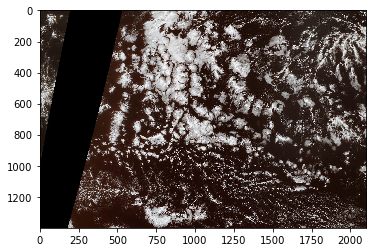

In [84]:
im = cv2.imread('test.jpg')
plt.imshow(im)

In [22]:
data_dir  = Path('../data/raw')
terra_dir = data_dir / 'terra'
aqua_dir  = data_dir / 'aqua'

terra_dir.mkdir(parents=True, exist_ok=True)
aqua_dir.mkdir(parents=True, exist_ok=True)

In [23]:
atlantic = np.array([10.08984375, -54.597656250000014,  25.48828125, -31.535156250000014])
south_atlantic = np.array([-21.48046875,  -28.160156250000014, -6.08203125, -5.097656250000014])
east_paficific = np.array([9.66796875, 132.01171875, 25.06640625, 155.07421875])
south_pacific_1 = np.array([-20.63671875, -110.56640624999997, -5.23828125, -87.50390624999997])
south_pacific_2 = np.array([ -20.49609375, -149.02734374999997,  -5.09765625, -125.96484374999997])
regions = np.array([atlantic, south_atlantic, east_paficific, south_pacific_1, south_pacific_2])

In [24]:
start_date = date(2012, 1, 1)
end_date   = date(2019, 7, 31)
print(start_date, end_date)

2012-01-01 2019-07-31


In [25]:
img_height = 1400
img_width = 2100

In [33]:
def get_urls():
    results = []
    for dt in rrule(DAILY, dtstart=startDate, until=endDate):
        target_date = dt.strftime("%Y-%m-%d")
        for bottom,left,top,right in regions:
            for source in ['Aqua', 'Terra']:
                results.append(format_url(
                    target_date,
                    bottom,left,top,right,
                    source,
                    img_height, img_width
                ))
    return results

def format_url(
    target_date,
    bottom,
    left, 
    top,
    right,
    source,
    height,
    width
):
    url_base = 'https://wvs.earthdata.nasa.gov/api/v1/snapshot?REQUEST=GetSnapshot&amp'
    url = ';'.join([
        url_base,
        f'TIME={target_date}T00:00:00Z&amp',
        f'BBOX={bottom},{left},{top},{right}&amp',
        f'CRS=EPSG:4326&amp',
        f'LAYERS=MODIS_{source}_CorrectedReflectance_TrueColor,Coastlines&amp',
        f'WRAP=day,x&amp',
        'FORMAT=image/jpeg&amp',
        f'WIDTH={width}&amp',
        f'HEIGHT={height}&amp',
        'ts=1569875246328',
    ])
    return url

In [34]:
urls = get_urls()
print("Number of urls:", len(urls))
print("Sample urls:", urls[1], '\n', urls[1])

Number of urls: 27690
Sample urls: https://wvs.earthdata.nasa.gov/api/v1/snapshot?REQUEST=GetSnapshot&amp;TIME=2012-01-01T00:00:00Z&amp;BBOX=10.08984375,-54.597656250000014,25.48828125,-31.535156250000014&amp;CRS=EPSG:4326&amp;LAYERS=MODIS_Terra_CorrectedReflectance_TrueColor,Coastlines&amp;WRAP=day,x&amp;FORMAT=image/jpeg&amp;WIDTH=2100&amp;HEIGHT=1400&amp;ts=1569875246328 
 https://wvs.earthdata.nasa.gov/api/v1/snapshot?REQUEST=GetSnapshot&amp;TIME=2012-01-01T00:00:00Z&amp;BBOX=10.08984375,-54.597656250000014,25.48828125,-31.535156250000014&amp;CRS=EPSG:4326&amp;LAYERS=MODIS_Terra_CorrectedReflectance_TrueColor,Coastlines&amp;WRAP=day,x&amp;FORMAT=image/jpeg&amp;WIDTH=2100&amp;HEIGHT=1400&amp;ts=1569875246328


In [35]:
r = requests.get(urls[0])

In [36]:
r.content

b'<?xml version=\'1.0\' encoding="UTF-8"?>\n<ServiceExceptionReport\n    xmlns="http://www.opengis.net/ogc"\n    xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"\n    version="1.3.0"\n    xsi:schemaLocation="http://www.opengis.net/ogc http://schemas.opengis.net/wms/1.3.0/exceptions_1_3_0.xsd">\n    <ServiceException code="MissingParameterValue">\n        Missing parameter value: LAYERS\n    </ServiceException>\n</ServiceExceptionReport>'

In [ ]:
def saveImages(urlPair):
    aquaUrl = urlPair[0]
    terraUrl = urlPair[1]
    aquaResponse = requests.get(aquaUrl)
    terraResponse = requests.get(terraUrl)

    aquaImg = Image.open(BytesIO(aquaResponse.content))
    terraImg = Image.open(BytesIO(terraResponse.content))

    name = ''.join(random.choice(string.ascii_uppercase + string.ascii_lowercase + string.digits) for _ in range(16))

    aquaImg.save("data/aqua/" + name + ".jpg")
    terraImg.save("data/terra/" + name + ".jpg")

    return name


results = ThreadPool(8).imap_unordered(saveImages, urls)